In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
import scipy.sparse as sparse
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Figure 3/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
hpoly = sc.read("../data/train_hpoly.h5ad")
hpoly

AnnData object with n_obs × n_vars = 5059 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [4]:
salmonella = sc.read("../data/train_salmonella.h5ad")
salmonella

AnnData object with n_obs × n_vars = 4259 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [5]:
hpoly_reconstructed = sc.read("../data/reconstructed/scGen/hpoly.h5ad")
salmonella_reconstructed = sc.read("../data/reconstructed/scGen/salmonella.h5ad")

### Figure 3.a

0.9705966791023235
0.9844520591667748


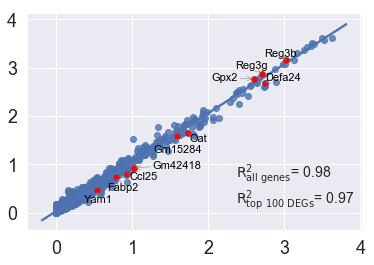

In [7]:
cell_type = "TA.Early"
conditions = {"ctrl": f"{cell_type}_ctrl", "pred_stim": f"{cell_type}_pred_stim", "real_stim": f"{cell_type}_real_stim"}
hpoly_cell = hpoly[hpoly.obs["cell_label"] == cell_type] 
sc.tl.rank_genes_groups(hpoly_cell, groupby="condition", n_genes=100, method="wilcoxon")
diff_genes = hpoly_cell.uns["rank_genes_groups"]["names"]["Hpoly.Day10"].tolist()[:50] \
           + hpoly_cell.uns["rank_genes_groups"]["names"]["Control"].tolist()[:50]
scgen.plotting.reg_mean_plot(hpoly_reconstructed, 
                             labels={"x": "", "y": ""},
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=diff_genes[:5] + diff_genes[50:55],
                             top_100_genes=diff_genes,
                             path_to_save=os.path.join(path_to_save, f"Fig3a_hpoly_reg_mean.pdf"),
                             legend=False,
                             fontsize=18,
                             textsize=14,
                             x_coeff=0.35,
                             title="",
                             show=True)

### Figure 3.b

0.9720322639792356
0.9812218771281388


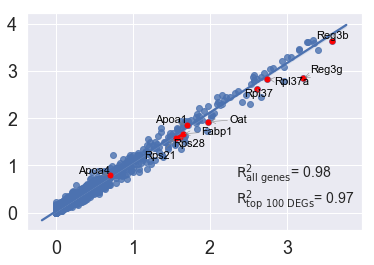

In [8]:
cell_type = "TA.Early"
conditions = {"ctrl": f"{cell_type}_ctrl", "pred_stim": f"{cell_type}_pred_stim", "real_stim": f"{cell_type}_real_stim"}
salmonella_cell = salmonella[salmonella.obs["cell_label"] == cell_type]
sc.tl.rank_genes_groups(salmonella_cell, groupby="condition", n_genes=100, method="wilcoxon")
diff_genes = salmonella_cell.uns["rank_genes_groups"]["names"]["Salmonella"].tolist()[:50] \
           + salmonella_cell.uns["rank_genes_groups"]["names"]["Control"].tolist()[:50]
scgen.plotting.reg_mean_plot(salmonella_reconstructed,
                             labels={"x": "", "y": ""},
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=diff_genes[:5] + diff_genes[50:55],
                             top_100_genes=diff_genes,
                             path_to_save=os.path.join(path_to_save, f"Fig3b_salmonella_reg_mean.pdf"),
                             fontsize=18, 
                             textsize=14,
                             x_coeff=0.35,
                             legend=False,
                             title="",
                             range=[0, 5, 1],
                             show=True)

### Figure 3.c

In [17]:
def calc_R2(adata, data_name, cell_type, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        adata_cell = adata[adata.obs["cell_label"] == cell_type]
        print(adata_cell.obs["condition"].unique().tolist())
        sc.tl.rank_genes_groups(adata_cell, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata_cell.uns["rank_genes_groups"]["names"][conditions["real_stim"]].tolist()[:n_genes//2] \
                   + adata_cell.uns["rank_genes_groups"]["names"][conditions["ctrl"]].tolist()[:n_genes//2]
        adata = adata[:, diff_genes]
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    for i in range(100):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
        if sparse.issparse(pred_stim.X):
            pred_stim.X = pred_stim.X.A
            real_stim.X = real_stim.X.A
        x = np.average(pred_stim.X[pred_stim_idx], axis=0)
        y = np.average(real_stim.X[real_stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    return r_values.mean(), r_values.std()

In [16]:
def calc_R2_mean_var(adata, data_name, cell_types, n_genes):
    r2_means, r2_vars = [], []
    for cell_type in cell_types:
        conditions = {"ctrl": cell_type+"_ctrl" ,"real_stim": cell_type+"_real_stim", "pred_stim": cell_type+"_pred_stim"}
        r2_mean, r2_var = calc_R2(adata, data_name, cell_type, n_genes=n_genes, conditions=conditions)
        r2_means.append(r2_mean)
        r2_vars.append(r2_var)
    return r2_means, r2_vars

In [12]:
cell_types = hpoly.obs["cell_label"].unique().tolist()
cell_types

['Enterocyte.Progenitor',
 'Stem',
 'TA.Early',
 'TA',
 'Tuft',
 'Enterocyte',
 'Goblet',
 'Endocrine']

In [18]:
r2_top100_means, r2_top100_vars = calc_R2_mean_var(hpoly_reconstructed, "hpoly", cell_types=cell_types, n_genes=100)
r2_all_means, r2_all_vars = calc_R2_mean_var(hpoly_reconstructed, "hpoly", cell_types=cell_types, n_genes=6998)

['Enterocyte.Progenitor_ctrl', 'Enterocyte.Progenitor_pred_stim', 'Enterocyte.Progenitor_real_stim']
['Stem_ctrl', 'Stem_pred_stim', 'Stem_real_stim']
['TA.Early_ctrl', 'TA.Early_pred_stim', 'TA.Early_real_stim']
['TA_ctrl', 'TA_pred_stim', 'TA_real_stim']
['Tuft_ctrl', 'Tuft_pred_stim', 'Tuft_real_stim']
['Enterocyte_ctrl', 'Enterocyte_pred_stim', 'Enterocyte_real_stim']
['Goblet_ctrl', 'Goblet_pred_stim', 'Goblet_real_stim']
['Endocrine_ctrl', 'Endocrine_pred_stim', 'Endocrine_real_stim']
['Enterocyte.Progenitor_ctrl', 'Enterocyte.Progenitor_pred_stim', 'Enterocyte.Progenitor_real_stim']
['Stem_ctrl', 'Stem_pred_stim', 'Stem_real_stim']
['TA.Early_ctrl', 'TA.Early_pred_stim', 'TA.Early_real_stim']
['TA_ctrl', 'TA_pred_stim', 'TA_real_stim']
['Tuft_ctrl', 'Tuft_pred_stim', 'Tuft_real_stim']
['Enterocyte_ctrl', 'Enterocyte_pred_stim', 'Enterocyte_real_stim']
['Goblet_ctrl', 'Goblet_pred_stim', 'Goblet_real_stim']
['Endocrine_ctrl', 'Endocrine_pred_stim', 'Endocrine_real_stim']


In [19]:
all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
all_types = ["top 100 DEGs"] * len(r2_top100_means) + ["all genes"] * len(r2_top100_means)
cell_types_x = 2 * cell_types
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
df

,R^2 Means,R^2 Stddevs,Type,Cell Types
0,0.943881,0.006032,top 100 DEGs,Enterocyte.Progenitor
1,0.948038,0.005146,top 100 DEGs,Stem
2,0.975915,0.002596,top 100 DEGs,TA.Early
3,0.954198,0.008118,top 100 DEGs,TA
4,0.861349,0.032096,top 100 DEGs,Tuft
5,0.862103,0.013010,top 100 DEGs,Enterocyte
6,0.897163,0.011955,top 100 DEGs,Goblet
7,0.879591,0.016294,top 100 DEGs,Endocrine
8,0.979003,0.001576,all genes,Enterocyte.Progenitor
9,0.982285,0.000958,all genes,Stem


In [20]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=14)

In [21]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, offset=0.375):
    plt.close("all")
    import matplotlib
    matplotlib.rc('ytick', labelsize=20)
    matplotlib.rc('xtick', labelsize=20)
    plt.figure(figsize=(10, 7))
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
#     offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
#     width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        if put_label:
            autolabel(b)
#         plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
#     plt.xlabel(cat)
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=20)
    plt.xticks(x_pos+offset, u, rotation=90)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_save, filename))
    plt.show()

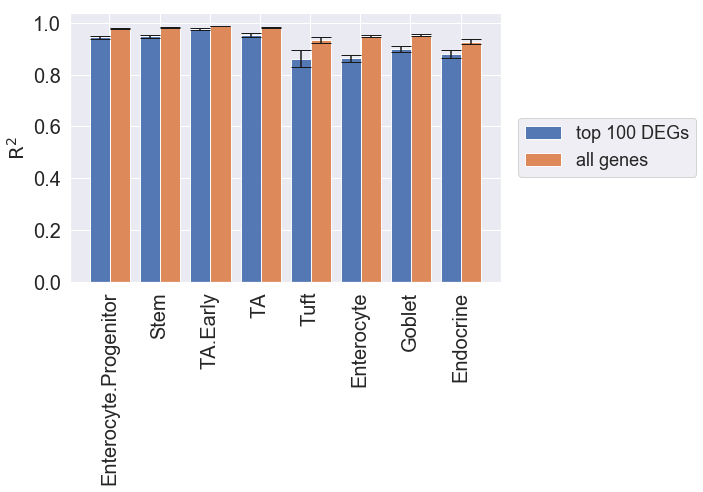

In [22]:
sns.set()
grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", filename="Fig3c_hpoly_celltypes_barplots.pdf")

### Figure 3.d

In [23]:
r2_top100_means, r2_top100_vars = calc_R2_mean_var(salmonella_reconstructed, "salmonella", cell_types=cell_types, n_genes=100)
r2_all_means, r2_all_vars = calc_R2_mean_var(salmonella_reconstructed, "salmonella", cell_types=cell_types, n_genes=6998)

['Enterocyte.Progenitor_ctrl', 'Enterocyte.Progenitor_pred_stim', 'Enterocyte.Progenitor_real_stim']
['Stem_ctrl', 'Stem_pred_stim', 'Stem_real_stim']
['TA.Early_ctrl', 'TA.Early_pred_stim', 'TA.Early_real_stim']
['TA_ctrl', 'TA_pred_stim', 'TA_real_stim']
['Tuft_ctrl', 'Tuft_pred_stim', 'Tuft_real_stim']
['Enterocyte_ctrl', 'Enterocyte_pred_stim', 'Enterocyte_real_stim']
['Goblet_ctrl', 'Goblet_pred_stim', 'Goblet_real_stim']
['Endocrine_ctrl', 'Endocrine_pred_stim', 'Endocrine_real_stim']
['Enterocyte.Progenitor_ctrl', 'Enterocyte.Progenitor_pred_stim', 'Enterocyte.Progenitor_real_stim']
['Stem_ctrl', 'Stem_pred_stim', 'Stem_real_stim']
['TA.Early_ctrl', 'TA.Early_pred_stim', 'TA.Early_real_stim']
['TA_ctrl', 'TA_pred_stim', 'TA_real_stim']
['Tuft_ctrl', 'Tuft_pred_stim', 'Tuft_real_stim']
['Enterocyte_ctrl', 'Enterocyte_pred_stim', 'Enterocyte_real_stim']
['Goblet_ctrl', 'Goblet_pred_stim', 'Goblet_real_stim']
['Endocrine_ctrl', 'Endocrine_pred_stim', 'Endocrine_real_stim']


In [24]:
all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
all_types = ["top 100 DEGs"] * len(r2_top100_means) + ["all genes"] * len(r2_top100_means)
cell_types_x = 2 * cell_types
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
df

,R^2 Means,R^2 Stddevs,Type,Cell Types
0,0.981292,0.004469,top 100 DEGs,Enterocyte.Progenitor
1,0.969801,0.004453,top 100 DEGs,Stem
2,0.974132,0.003267,top 100 DEGs,TA.Early
3,0.976524,0.003999,top 100 DEGs,TA
4,0.689121,0.083747,top 100 DEGs,Tuft
5,0.896783,0.006733,top 100 DEGs,Enterocyte
6,0.900636,0.024571,top 100 DEGs,Goblet
7,0.841250,0.035535,top 100 DEGs,Endocrine
8,0.986513,0.001191,all genes,Enterocyte.Progenitor
9,0.983257,0.000967,all genes,Stem


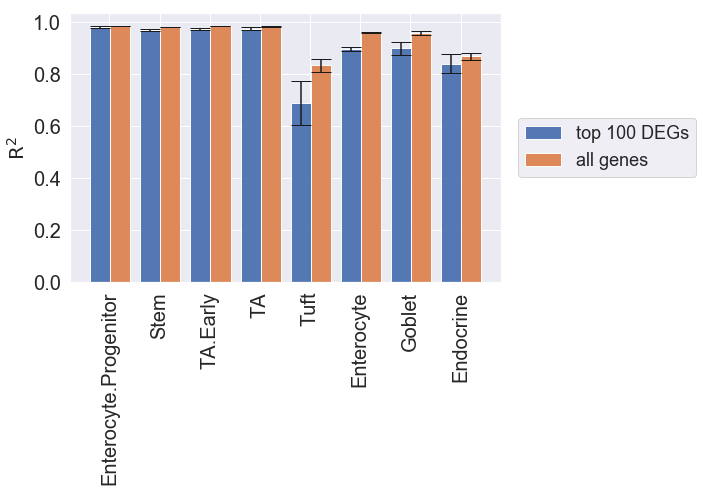

In [25]:
grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", filename="Fig3d_salmonella_celltypes_barplots.pdf")